In [ ]:
from numpy.linalg import svd
"""
Maze environment used in the first three modules of the course:
"Beginner to Master: Reinforcement Learning".
"""


from typing import Tuple, Dict, Optional, Iterable, List

import numpy as np
from collections import deque
import random

import gym
from gym import spaces
from gym.error import DependencyNotInstalled

import pygame
from pygame import gfxdraw



class Maze(gym.Env):
    """
    Description:
        The environment consists of a grid of (size x size) positions. The agent
        starts the episode in location (row=0, col=0) if the environment is instantiated
        without exploring starts or from a random location (different from the goal)
         if it is. The goal is always at (row=size-1, col=size-1).
    Observation:
        Type: MultiDiscrete(2)
        Num     Observation     Min     Max
        0       row coordinate    0       size-1
        1       col coordinate    0       size-1
    Actions:
        Type: Discrete(4)
        Num     Action
        0       Move up
        1       Move right
        2       Move down
        3       Move left
    Reward:
        If the environment is instantiated with shaped rewards, then at each time step
        the agent will receive a reward signal of the following magnitude:

            r = - steps_to_goal(current_state) / steps_to_goal(furthest_state)

        This ensures that the maximum reward awarded will be -1.0 and that at the goal
        the reward will be 0.

        If the environment is instantiated without shaped rewards, then at each time step
        the agent will receive a reward of -1.0 until it reaches the goal.
    Episode termination:
        The episode terminates when the agent reaches the goal state.
    """

    def __init__(self, exploring_starts: bool = True,
                 shaped_rewards: bool = False, size: int = 6) -> None:
        """
        Initialize the environment.

        Args:
            exploring_starts: should the agent restart at a random location or not.
            shaped_rewards: should the environment shape the rewards.
            size: size of the maze. Will be of shape (size x size).
        """
        super().__init__()
        self.exploring_starts = exploring_starts
        self.trap_states = [(2, 2)] #example trap state for now
        self.ice_states = [(4,2)]
        self.wizard_states = [(0,4)]

        self.shaped_rewards = shaped_rewards
        self.state = (size - 1, size - 1)
        self.goal = (size - 1, size - 1)
        self.maze = self._create_maze(size=size)
        self.distances = self._compute_distances(self.goal, self.maze)
        self.action_space = spaces.Discrete(n=4)
        self.action_space.action_meanings = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: "LEFT"}
        self.observation_space = spaces.MultiDiscrete([size, size])

        self.screen = None
        self.agent_transform = None

    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, Dict]:
        """
        Take an action in the environment and observe the next transition.

        Args:
            action: An indicator of the action to be taken.

        Returns:
            The next transition.
        """
        reward = self.compute_reward(self.state, action)
        next_state = self._get_next_state(self.state, action)

        if next_state in self.ice_states:
          next_next_state = self._get_next_state(next_state, action)
          self.state = next_next_state
        elif next_state in self.wizard_states:
          self.state = self._get_random_state()
        else:
          self.state = next_state

        done = self.state == self.goal
        info = {}

        return self.state, reward, done, info
       

    def reset(self) -> Tuple[int, int]:
        
        #changed this to always change after a new episode. For some reason with the other one if it found a bad space it 
        #would not change the starting square and mess up the statistics
        """
        self.state = tuple(self.observation_space.sample())
        while self.state == self.goal:
            self.state = tuple(self.observation_space.sample())
        return self.state
        """
        #Reset the environment to execute a new episode.

        #Returns: State representing the initial position of the agent.
        
        if self.exploring_starts:
          self.state = tuple(self.observation_space.sample())
          while self.state == self.goal:
             self.state = tuple(self.observation_space.sample())
        else:
            self.state = (0, 0)
        return self.state
       
    def render(self, mode: str = 'human') -> Optional[np.ndarray]:
        """
        Render a state of the environment.

        Args:
            mode: one of 'human' or 'rgb_array'. Human added only for compatibility.
            All rendering will be done in 'rgb arrays' via NumPy.

        Returns:
            A numpy.ndarray or None.

        """
        assert mode in ['human', 'rgb_array']

        screen_size = 600
        scale = screen_size / 6

        if self.screen is None:
            pygame.init()
            self.screen = pygame.Surface((screen_size, screen_size))

        surf = pygame.Surface((screen_size, screen_size))
        surf.fill((22, 36, 71))

        for row in range(6):
            for col in range(6):
                state = (row, col)
                if state in self.trap_states:
                  left = col*scale
                  right = (col + 1) * scale
                  top = (6 - row - 1) * scale
                  bottom = (6 - row) * scale
                  gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (100, 100, 100))
                if state in self.ice_states:
                  left = col*scale
                  right = (col + 1) * scale
                  top = (6 - row - 1) * scale
                  bottom = (6 - row) * scale
                  gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (162,210,223))
                if state in self.wizard_states:
                  left = col*scale
                  right = (col + 1) * scale
                  top = (6 - row - 1) * scale
                  bottom = (6 - row) * scale
                  gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255,0,0))

                for next_state in [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]:
                    if next_state not in self.maze[state]:

                        # Add the geometry of the edges and walls (i.e. the boundaries between
                        # adjacent squares that are not connected).
                        row_diff, col_diff = np.subtract(next_state, state)
                        left = (col + (col_diff > 0)) * scale - 2 * (col_diff != 0)
                        right = ((col + 1) - (col_diff < 0)) * scale + 2 * (col_diff != 0)
                        top = (6 - (row + (row_diff > 0))) * scale - 2 * (row_diff != 0)
                        bottom = (6 - ((row + 1) - (row_diff < 0))) * scale + 2 * (row_diff != 0)

                        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (255, 255, 255))

        # Add the geometry of the goal square to the viewer.
        left, right, top, bottom = scale * 5 + 6, scale * 10 - 10, scale - 10, 10
        gfxdraw.filled_polygon(surf, [(left, bottom), (left, top), (right, top), (right, bottom)], (40, 199, 172))

        # Add the geometry of the agent to the viewer.
        agent_row = int(screen_size - scale * (self.state[0] + .5))
        agent_col = int(scale * (self.state[1] + .5))
        gfxdraw.filled_circle(surf, agent_col, agent_row, int(scale * .6 / 2), (228, 63, 90))

        surf = pygame.transform.flip(surf, False, True)
        self.screen.blit(surf, (0, 0))

        return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self) -> None:
        """
        Clean up resources before shutting down the environment.

        Returns: None.
        """
        if self.screen is not None:
            pygame.display.quit()
            pygame.quit()
            self.screen = None

    def compute_reward(self, state: Tuple[int, int], action: int) -> float:
        """
        Compute the reward attained by taking action 'a' at state 's'.

        Args:
            state: the state of the agent prior to taking the action.
            action: the action taken by the agent.

        Returns:
            A float representing the reward signal received by the agent.

        """
        next_state = self._get_next_state(state, action)

        if next_state in self.trap_states:
          if random.random() < 0.1:
            return -10.0

        if self.shaped_rewards:
            return - (self.distances[next_state] / self.distances.max())
        return - float(state != self.goal)

    def simulate_step(self, state: Tuple[int, int], action: int):
        """

        Simulate (without taking) a step in the environment.

        Args:
            state: the state of the agent prior to taking the action.
            action: the action to simulate the step with.

        Returns:
            The next transition.
        """
        
        reward = self.compute_reward(state, action)
        next_state = self._get_next_state(state, action)
        done = next_state == self.goal
        info = {}
        return next_state, reward, done, info


    def _get_next_state(self, state: Tuple[int, int], action: int) -> Tuple[int, int]:
        """
        Gets the next state after the agent performs action 'a' in state 's'. If there is a
        wall in the way, the next state will be the same as the current.

        Args:
            state: current state (before taking the action).
            action: move performed by the agent.

        Returns: a State instance representing the new state.
        """
        if action == 0:
            next_state = (state[0] - 1, state[1])
        elif action == 1:
            next_state = (state[0], state[1] + 1)
        elif action == 2:
            next_state = (state[0] + 1, state[1])
        elif action == 3:
            next_state = (state[0], state[1] - 1)
        else:
            raise ValueError("Action value not supported:", action)
        if next_state in self.maze[state]:
            return next_state
        return state
      
    def _get_random_state(self) -> Tuple[int, int]:
        """
        Get a random state from the available states in the environment.

        Returns:
            A random state.
        """
        states = list(set(self.maze.keys()) - {self.goal} - set(self.trap_states) - set(self.ice_states) - set(self.wizard_states))
        return random.choice(states)

    @staticmethod
    def _create_maze(size: int) -> Dict[Tuple[int, int], List[Tuple[int, int]]]:
        """
        Creates a representation of the maze as a dictionary where the keys are
        the states available to the agent and the values are lists of adjacent
        states.

        Args:
            size: number of elements of each side in the square grid.

        Returns: the adjacency list dictionary.
        """
        maze = {(row, col): [] for row in range(size) for col in range(size)}
        visited = set()

        def dfs(node):
            visited.add(node)

            directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
            random.shuffle(directions)

            for direction in directions:
                next_node = (node[0] + direction[0], node[1] + direction[1])

                if next_node not in visited and next_node in maze:
                    maze[node].append(next_node)
                    maze[next_node].append(node)
                    dfs(next_node)

        dfs((0, 0))

        return maze


    @staticmethod
    def _compute_distances(goal: Tuple[int, int],
                           maze: Dict[Tuple[int, int], Iterable[Tuple[int, int]]]) -> np.ndarray:
        """
        Compute the distance to the goal from all other positions in the maze using Dijkstra's
        algorithm.

        Args:
            goal: A tuple representing the location of the goal in a two-dimensional grid.
            maze: A dictionary holding the adjacency lists of all locations in the
            two-dimensional grid.

        Returns: A (H x W) numpy array holding the minimum number of moves for each position
        to reach the goal.

        """
        distances = np.full((6, 6), np.inf)
        visited = set()
        distances[goal] = 0.

        while visited != set(maze):
            sorted_dst = [(v // 6, v % 6) for v in distances.argsort(axis=None)]
            closest = next(x for x in sorted_dst if x not in visited)
            visited.add(closest)

            for neighbour in maze[closest]:
                distances[neighbour] = min(distances[neighbour], distances[closest] + 1)
        return distances


    
env = Maze()
env.reset()
env.render(mode='rgb_array')
    



array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [ 22,  36,  71],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
import gym
import numpy as np
import os
os.environ["KNP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.pyplot as plt
from typing import Callable
import seaborn as sns
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt



In [ ]:
def plot_policy(probs_or_qvals, frame, action_meanings=None):
    if action_meanings is None:
        action_meanings = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    max_prob_actions = probs_or_qvals.argmax(axis=-1)
    probs_copy = max_prob_actions.copy().astype(np.object)
    for key in action_meanings:
        probs_copy[probs_copy == key] = action_meanings[key]
    sns.heatmap(max_prob_actions, annot=probs_copy, fmt='', cbar=False, cmap='coolwarm',
                annot_kws={'weight': 'bold', 'size': 12}, linewidths=2, ax=axes[0])
    axes[1].imshow(frame)
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle("Policy", size=24)
    plt.tight_layout()
    
def plot_action_values(action_values):

    text_positions = [
        [(0.35, 4.75), (1.35, 4.75), (2.35, 4.75), (3.35, 4.75), (4.35, 4.75),
         (0.35, 3.75), (1.35, 3.75), (2.35, 3.75), (3.35, 3.75), (4.35, 3.75),
         (0.35, 2.75), (1.35, 2.75), (2.35, 2.75), (3.35, 2.75), (4.35, 2.75),
         (0.35, 1.75), (1.35, 1.75), (2.35, 1.75), (3.35, 1.75), (4.35, 1.75),
         (0.35, 0.75), (1.35, 0.75), (2.35, 0.75), (3.35, 0.75), (4.35, 0.75)],
        [(0.6, 4.45), (1.6, 4.45), (2.6, 4.45), (3.6, 4.45), (4.6, 4.45),
         (0.6, 3.45), (1.6, 3.45), (2.6, 3.45), (3.6, 3.45), (4.6, 3.45),
         (0.6, 2.45), (1.6, 2.45), (2.6, 2.45), (3.6, 2.45), (4.6, 2.45),
         (0.6, 1.45), (1.6, 1.45), (2.6, 1.45), (3.6, 1.45), (4.6, 1.45),
         (0.6, 0.45), (1.6, 0.45), (2.6, 0.45), (3.6, 0.45), (4.6, 0.45)],
        [(0.35, 4.15), (1.35, 4.15), (2.35, 4.15), (3.35, 4.15), (4.35, 4.15),
         (0.35, 3.15), (1.35, 3.15), (2.35, 3.15), (3.35, 3.15), (4.35, 3.15),
         (0.35, 2.15), (1.35, 2.15), (2.35, 2.15), (3.35, 2.15), (4.35, 2.15),
         (0.35, 1.15), (1.35, 1.15), (2.35, 1.15), (3.35, 1.15), (4.35, 1.15),
         (0.35, 0.15), (1.35, 0.15), (2.35, 0.15), (3.35, 0.15), (4.35, 0.15)],
        [(0.05, 4.45), (1.05, 4.45), (2.05, 4.45), (3.05, 4.45), (4.05, 4.45),
         (0.05, 3.45), (1.05, 3.45), (2.05, 3.45), (3.05, 3.45), (4.05, 3.45),
         (0.05, 2.45), (1.05, 2.45), (2.05, 2.45), (3.05, 2.45), (4.05, 2.45),
         (0.05, 1.45), (1.05, 1.45), (2.05, 1.45), (3.05, 1.45), (4.05, 1.45),
         (0.05, 0.45), (1.05, 0.45), (2.05, 0.45), (3.05, 0.45), (4.05, 0.45)]]

    fig, ax = plt.subplots(figsize=(9, 9))
    tripcolor = quatromatrix(action_values, ax=ax,
                             triplotkw={"color": "k", "lw": 1}, tripcolorkw={"cmap": "coolwarm"})
    ax.margins(0)
    ax.set_aspect("equal")
    fig.colorbar(tripcolor)

    for j, av in enumerate(text_positions):
        for i, (xi, yi) in enumerate(av):
            plt.text(xi, yi, round(action_values[:, :, j].flatten()[i], 2), size=10, color="w", weight="bold")

    plt.title("Action values Q(s,a)", size=18)
    plt.tight_layout()
    plt.show()
    
def test_agent(env: gym.Env, policy: Callable, episodes: int = 10, step_limit: int = 25) -> int:
    plt.figure(figsize=(8, 8))
    success_count = 0
    for episode in range(episodes):
        state = env.reset()
        done = False
        img = plt.imshow(env.render())
        step_count = 0  # initialize step count to zero for each episode
        while not done:
            p = policy(state)                     
            if isinstance(p, np.ndarray):         
                action = np.random.choice(4, p=p) 
            else:
                action = p
            next_state, _, done, _ = env.step(action) 
            img.set_data(env.render())
            plt.axis('off')
            display(plt.gcf())
            clear_output(wait=True)
            state = next_state
            step_count += 1
            if step_count >= step_limit:  # terminate the episode if step limit is exceeded
                break
        if done:
            success_count += 1
    return success_count

def quatromatrix(action_values, ax=None, triplotkw=None, tripcolorkw=None):
    action_values = np.flipud(action_values)
    n = 5
    m = 5
    a = np.array([[0, 0], [0, 1], [.5, .5], [1, 0], [1, 1]])
    tr = np.array([[0, 1, 2], [0, 2, 3], [2, 3, 4], [1, 2, 4]])
    A = np.zeros((n * m * 5, 2))
    Tr = np.zeros((n * m * 4, 3))
    for i in range(n):
        for j in range(m):
            k = i * m + j
            A[k * 5:(k + 1) * 5, :] = np.c_[a[:, 0] + j, a[:, 1] + i]
            Tr[k * 4:(k + 1) * 4, :] = tr + k * 5
    C = np.c_[action_values[:, :, 3].flatten(), action_values[:, :, 2].flatten(),
              action_values[:, :, 1].flatten(), action_values[:, :, 0].flatten()].flatten()

    ax.triplot(A[:, 0], A[:, 1], Tr, **triplotkw)
    tripcolor = ax.tripcolor(A[:, 0], A[:, 1], Tr, facecolors=C, **tripcolorkw)
    return tripcolor



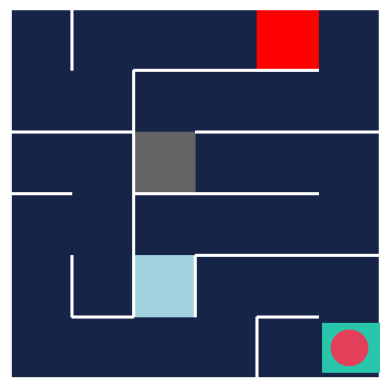

Observation space shape: [6 6]
Number of actions: 4


In [ ]:
import matplotlib.pyplot as plt
env = Maze()

frame = env.render(mode='rgb_array')

plt.axis('off')
plt.imshow(frame)
plt.show()

print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")


In [ ]:
action_values = np.zeros(shape = (6,6,4))

In [ ]:
def policy(state, epsilon = 0.):
    if np.random.random() < epsilon:
        return np.random.randint(4)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

In [ ]:
av = action_values[(0,0)]
av = np.array([1,7,2,1])
av == av.max()

array([False,  True, False, False])

In [ ]:
av = action_values[(0,0)]
av = np.array([1,7,5,6])
np.flatnonzero(av == av.max())

array([1])

In [ ]:
def test_agent_no_image(env: gym.Env, policy: Callable, episodes: int = 100, max_steps: int = 36) -> float:
    success_count = 0
    for episode in range(episodes):
        state = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps:
            action = policy(state)
            state, _, done, _ = env.step(action)
            steps += 1
        if done:
            success_count += 1
    success_rate = (success_count / episodes) * 100
    return success_rate

In [ ]:
from tqdm import tqdm
import time

def on_policy_mc(policy, action_values, episodes, gamma=0.99, epsilon=0.2):
    sa_values = {}  # will hold a key of (state, action) and value of value
    max_execution_time = 100
    for _ in tqdm(range(episodes)):
        start_time = time.time()
        state = env.reset()
        # generate a trajectory
        trajectory = []
        done = False
        while not done:
            # do stuff, take steps, find the goal
            # decide on an action
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            trajectory.append([state, action, reward])
            state = next_state
            elapsed_time = time.time() - start_time
            if elapsed_time >= max_execution_time:
                break
        # trajectory now holds all relevant information
        # loop through trajectory backwards to get rewards
        G = 0
        for i in range(len(trajectory) - 1, 0, -1):
            s = trajectory[i][0]
            a = trajectory[i][1]
            r = trajectory[i][2]
            G = r + gamma * G
            if not (s, a) in sa_values:
                sa_values[(s, a)] = []
            sa_values[(s, a)].append(G)
            #action_values[s][a] = np.mean(sa_values[(s, a)])
            action_values[s][a] = action_values[s][a] + epsilon * (G - action_values[s][a])

In [ ]:
action_values = np.zeros(shape = (6,6,4))
on_policy_mc(policy, action_values, 500)
test_agent_no_image(env, policy)

100%|██████████| 500/500 [01:06<00:00,  7.58it/s]


48.0

In [ ]:
test_agent_no_image(env, policy)

39.0

5

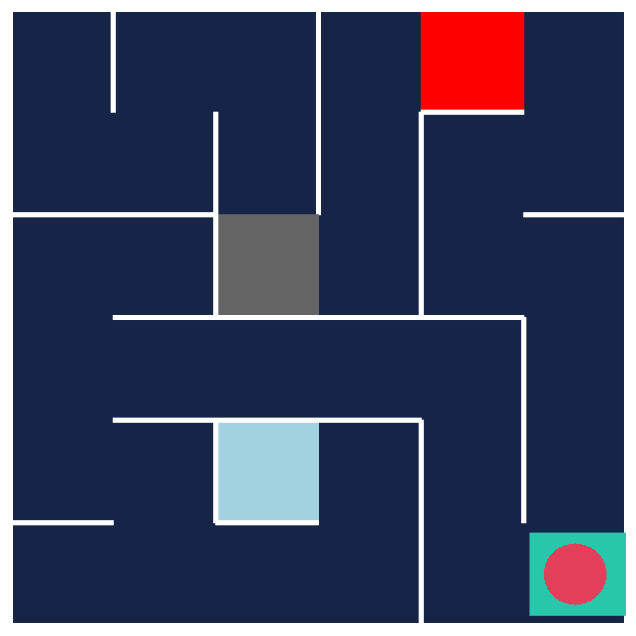

In [ ]:
test_agent(env, policy, 5, 36)

100%|██████████| 10/10 [01:21<00:00,  8.20s/it]


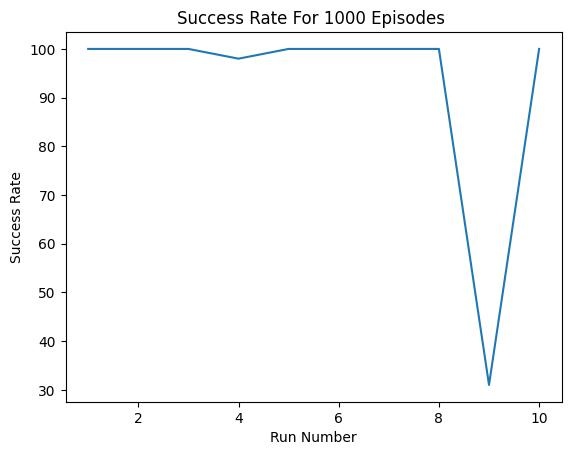

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

n_runs = 10
success_rates = []
action_values = np.zeros(shape=(6, 6, 4))

for i in tqdm(range(n_runs)):
    on_policy_mc(policy, action_values, 1000)
    success_rate = test_agent_no_image(env, policy)
    success_rates.append(success_rate)

plt.plot(range(1, n_runs+1), success_rates)
plt.xlabel('Run Number')
plt.ylabel('Success Rate')
plt.title('Success Rate For 1000 Episodes ')

plt.show()


100%|██████████| 10/10 [01:18<00:00,  7.82s/it]


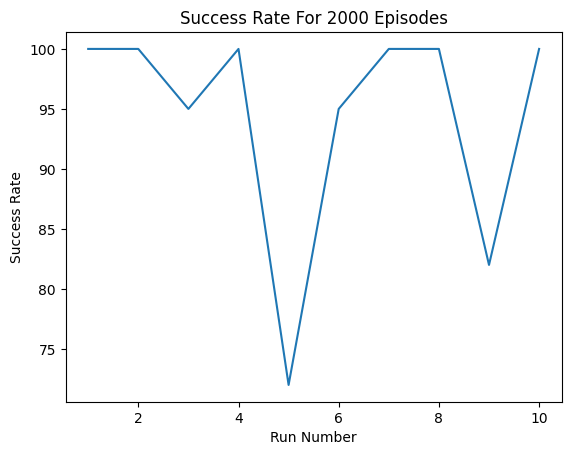

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

n_runs = 10
success_rates = []
action_values = np.zeros(shape=(6, 6, 4))


for i in tqdm(range(n_runs)):
    on_policy_mc(policy, action_values, 2000)
    success_rate = test_agent_no_image(env, policy)
    success_rates.append(success_rate)

plt.plot(range(1, n_runs+1), success_rates)
plt.xlabel('Run Number')
plt.ylabel('Success Rate')
plt.title('Success Rate For 2000 Episodes')

plt.show()


100%|██████████| 10/10 [03:23<00:00, 20.33s/it]


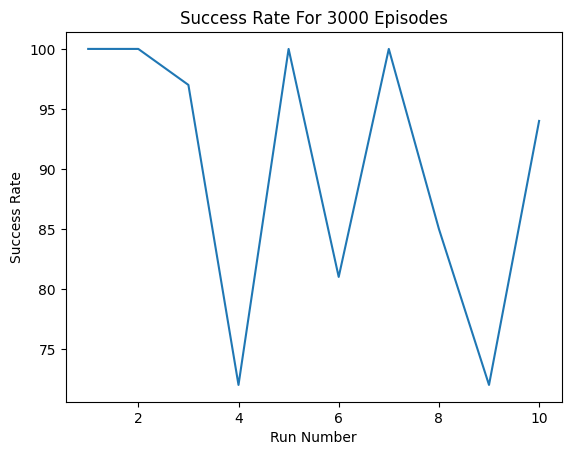

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

action_values = np.zeros(shape=(6, 6, 4))

n_runs = 10
success_rates = []

for i in tqdm(range(n_runs)):
    on_policy_mc(policy, action_values, 3000)
    success_rate = test_agent_no_image(env, policy)
    success_rates.append(success_rate)

plt.plot(range(1, n_runs+1), success_rates)
plt.xlabel('Run Number')
plt.ylabel('Success Rate')
plt.title('Success Rate For 3000 Episodes')

plt.show()


100%|██████████| 10/10 [00:59<00:00,  5.96s/it]


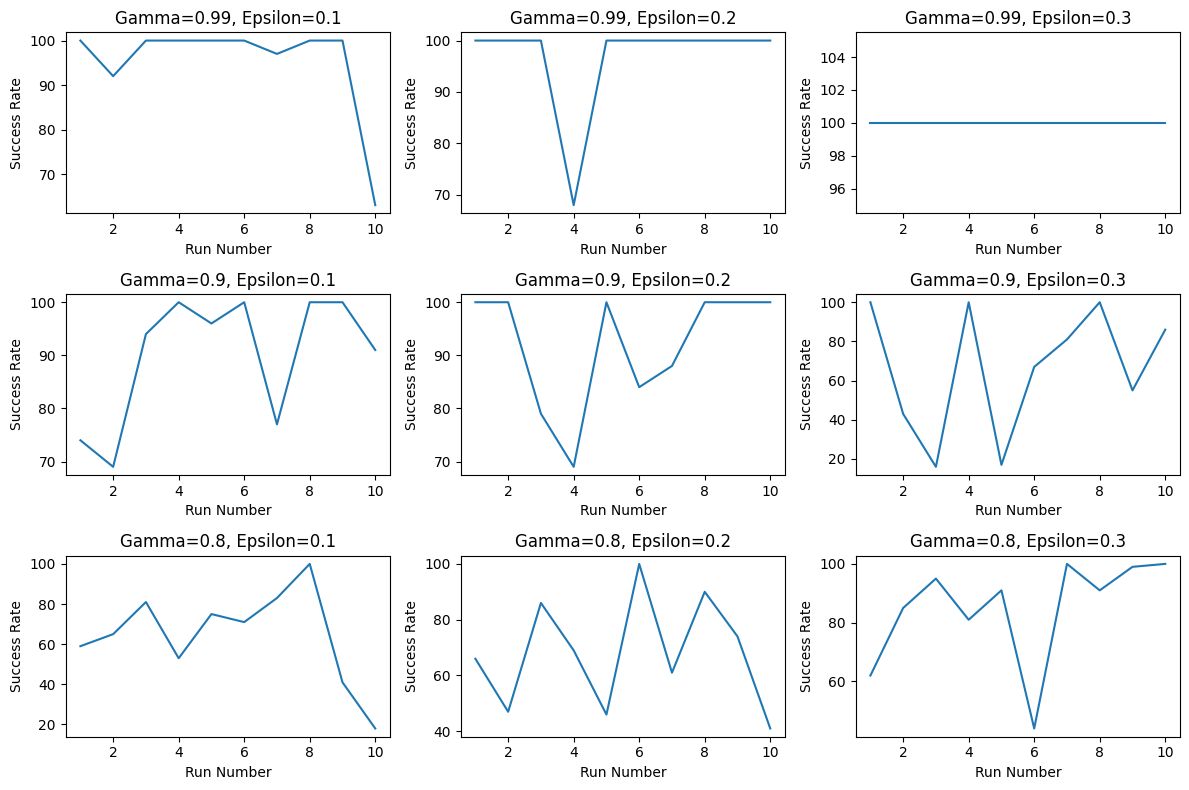

In [ ]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

n_runs = 10
epsilon_values = [0.1, 0.2, 0.3]
gamma_values = [0.99, 0.90, 0.80]
action_values = np.zeros(shape=(6, 6, 4))


success_rates = []

for epsilon in epsilon_values:
    for gamma in gamma_values:
        gamma_epsilon_success_rates = []
        for i in tqdm(range(n_runs)):
            on_policy_mc(policy, action_values, 3000, gamma, epsilon)
            success_rate = test_agent_no_image(env, policy)
            gamma_epsilon_success_rates.append(success_rate)
        success_rates.append(gamma_epsilon_success_rates)

# Plot the results
fig, axs = plt.subplots(len(gamma_values), len(epsilon_values), figsize=(12, 8))
for i in range(len(gamma_values)):
    for j in range(len(epsilon_values)):
        axs[i][j].plot(range(1, n_runs+1), success_rates[i*len(epsilon_values) + j])
        axs[i][j].set_xlabel('Run Number')
        axs[i][j].set_ylabel('Success Rate')
        axs[i][j].set_title(f'Gamma={gamma_values[i]}, Epsilon={epsilon_values[j]}')
plt.tight_layout()
plt.show()



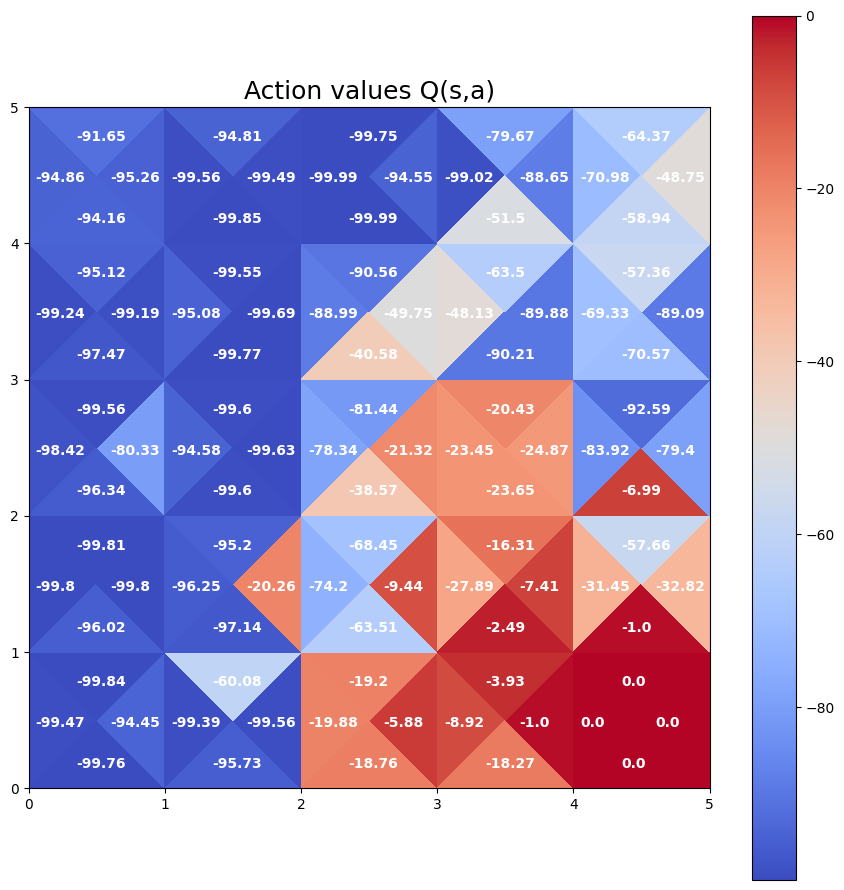

In [ ]:
plot_action_values(action_values)

<ipython-input-3-06832ee365d1>:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  probs_copy = max_prob_actions.copy().astype(np.object)


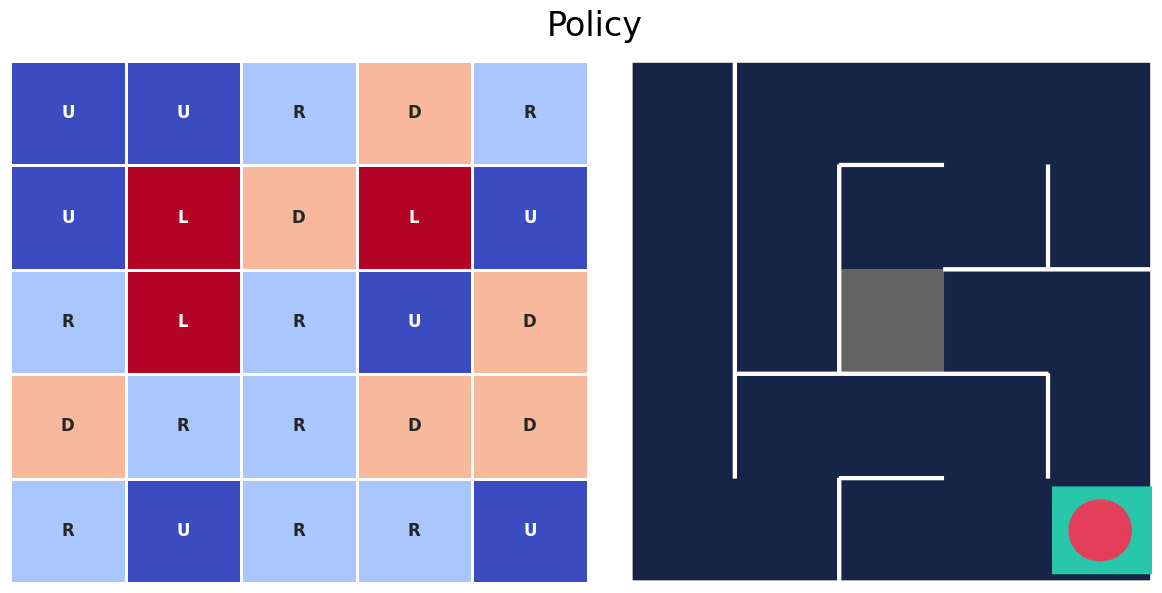

In [ ]:
plot_policy(action_values, frame)

In [ ]:
test_agent(env, policy, episodes = 5)